In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import json
import tqdm
import random
from itertools import product
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# from msdm.domains import GridWorld
from msdm.algorithms import PolicyIteration
from msdm.core.distributions import SoftmaxDistribution

from construal_shifting.fastgridworld import GridWorld2 as GridWorld
from construal_shifting.utils import maze_code
from construal_shifting.construal import construal_level, construal_utility, construal_size, calculate_construal_dist, maze_construals
from construal_shifting import gridutils, sampsat

import pandas as pd
import numpy as np

MAIN_OBSTACLE_COLOR = (173/255, 216/255, 230/255, 1.)
BROKEN_OBSTACLE_COLOR = (173/255, 216/255, 230/255, .5)

In [2]:
test_mazes = json.load(open("./mazes/test_mazes.json", 'r'))
coarse_test_mazes = {
    f"{r['idx']}-coarse-test": r['maze']
    for r in test_mazes if r['bias'] == 'coarse'
}
assert len(coarse_test_mazes) == 4
fine_test_mazes = {
    f"{r['idx']}-fine-test": r['maze']
    for r in test_mazes if r['bias'] == 'fine'
}
assert len(fine_test_mazes) == 4
both_test_mazes = {
    f"{r['idx']}-both-test": r['maze']
    for r in test_mazes if r['bias'] == 'both'
}
assert len(both_test_mazes) == 4

training_mazes = json.load(open("./mazes/training_mazes.json", 'r'))
fine_training_mazes = {
    f"{r['idx']}-{r['bias']}-train": r['maze'] 
    for r in training_mazes if r['bias'] == 'fine'
}
assert len(fine_training_mazes) == 8

coarse_training_mazes = {
    f"{r['idx']}-{r['bias']}-train": r['maze'] 
    for r in training_mazes if r['bias'] == 'coarse'
}
assert len(coarse_training_mazes) == 8

In [3]:
def is_coarse(c):
    notches = set(c) & set('abcdefg')
    return len(notches) == 0
def is_fine(c):
    notches = set(c) & set('abcdefg')
    return len(notches) > 0

def construal_to_wall_array(c):
    wall_arr = []
    for row in c.split('\n'):
        wall_arr.append([])
        for char in row:
            if char in "ABCDEFG#":
                wall = 1
            elif char in "abcdefg":
                wall = .5
            else:
                wall = 0
            wall_arr[-1].append(wall)
    return np.array(wall_arr)

def plot_wall_array(wall_arr, gw_params, true_tile_array, ax=None):
    height, width = wall_arr.shape
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.set_xlim(-0.1, width + .1)
    ax.set_ylim(-0.1, height + .1)
    ax.set_aspect('equal')

    for x, y in product(range(width), range(height)):
        if true_tile_array[-(y + 1)][x] == '#':
            facecolor = 'k'
        else:
            alpha = wall_arr[-(y + 1)][x]
            if alpha == 0:
                facecolor = 'w'
            else:
                facecolor = MAIN_OBSTACLE_COLOR[:-1] + (alpha,)
        square = Rectangle(
            (x, y), 1, 1,
            facecolor=facecolor,
            edgecolor='darkgrey',
            linewidth=2
        )
        ax.add_patch(square)
    outerbox = Rectangle(
        (0, 0), width, height,
        fill=False, edgecolor='black',
        linewidth=2
    )
    ax.add_patch(outerbox)

    return ax

In [11]:
def calculate_critical_broken_locs(tile_array):
    gw = GridWorld(
        tile_array=tile_array,
        wall_features="ABCDEFG#",
        absorbing_features="$",
        initial_features="@",
        step_cost=-1
    )
    pi = PolicyIteration().plan_on(gw)
    unavoidable_locs = {loc for loc, prob in pi.policy.evaluate_on(gw).state_occupancy.items() if prob == 1.0}
    broken_locs = set([])
    for f in 'abcdef':
        if f in gw.feature_locations:
            broken_locs.update(gw.feature_locations[f])
    return broken_locs & unavoidable_locs

In [12]:
def calc_cset_vor(tile_array, gw_params, construal_size_weight, invtemp):
    utilities = {}
    sizes = {}
    coarse_vor = {}
    fine_vor = {}
    maze = '\n'.join(tile_array)
    for c in maze_construals(maze):
        utility = construal_utility(c, maze, gw_params)
        utilities[c] = utility
        c_size = construal_size(c)
        sizes[c] = c_size
        vor = utility - construal_size_weight*c_size
        if is_coarse(c):
            coarse_vor[c] = vor
        if is_fine(c):
            fine_vor[c] = vor
    coarse_pi = SoftmaxDistribution({c: invtemp*v for c, v in coarse_vor.items()})
    coarse_utility = coarse_pi.expectation(lambda c: utilities[c])
    coarse_size = coarse_pi.expectation(lambda c: sizes[c])
    coarse_val = coarse_pi.expectation(lambda c: coarse_vor[c])
    coarse_wall_arr = coarse_pi.expectation(lambda c: construal_to_wall_array(c))
    
    fine_pi = SoftmaxDistribution({c: invtemp*v for c, v in fine_vor.items()})
    fine_utility = fine_pi.expectation(lambda c: utilities[c])
    fine_size = fine_pi.expectation(lambda c: sizes[c])
    fine_val = fine_pi.expectation(lambda c: fine_vor[c])
    fine_wall_arr = fine_pi.expectation(lambda c: construal_to_wall_array(c))
    return dict(
        fine_exp_vor=fine_val,
        coarse_exp_vor=coarse_val,
        coarse_exp_utility=coarse_utility,
        coarse_exp_size=coarse_size,
        coarse_wall_arr=coarse_wall_arr,
        fine_exp_utility=fine_utility,
        fine_exp_size=fine_size,
        fine_wall_arr=fine_wall_arr
    )

In [13]:
# exp_wall_array = fine_pi.expectation(lambda c: construal_to_wall_array(c))
# plot_wall_array(exp_wall_array, gw_params, tile_array)

In [14]:
gw_params = dict(
    initial_features='@',
    absorbing_features='$',
    wall_features='#ABCDEFGHIJK',
    discount_rate=.9999,
    wall_bump_cost=-10
)

calc_cset_vor_params = dict(
    gw_params = gw_params,
    construal_size_weight = 1,
    invtemp = 100
)
    
maze_stats = []
    
for maze_name, tile_array in tqdm.tqdm(fine_training_mazes.items()):
    record = dict(
        maze_name=maze_name,
        tile_array=tuple(tile_array), 
        construal_set_bias="fine_bias",
        trial_type="fine-training",
        training=True,
        test=False
    )
    cset_vors = calc_cset_vor(tile_array, **calc_cset_vor_params)
    record.update(cset_vors)
    maze_stats.append(record)
    
for maze_name, tile_array in tqdm.tqdm(coarse_training_mazes.items()):
    record = dict(
        maze_name=maze_name,
        tile_array=tuple(tile_array), 
        construal_set_bias="coarse_bias",
        trial_type="coarse-training",
        training=True,
        test=False
    )
    cset_vors = calc_cset_vor(tile_array, **calc_cset_vor_params)
    record.update(cset_vors)
    maze_stats.append(record)
    
for maze_name, tile_array in tqdm.tqdm(fine_test_mazes.items()):
    record = dict(
        maze_name=maze_name,
        tile_array=tuple(tile_array), 
        construal_set_bias="fine_bias",
        trial_type="fine-test",
        training=False,
        test=True
    )
    cset_vors = calc_cset_vor(tile_array, **calc_cset_vor_params)
    record.update(cset_vors)
    maze_stats.append(record)
    
for maze_name, tile_array in tqdm.tqdm(coarse_test_mazes.items()):
    record = dict(
        maze_name=maze_name,
        tile_array=tuple(tile_array), 
        construal_set_bias="coarse_bias",
        trial_type="coarse-test",
        training=False,
        test=True
    )
    cset_vors = calc_cset_vor(tile_array, **calc_cset_vor_params)
    record.update(cset_vors)
    maze_stats.append(record)

for maze_name, tile_array in tqdm.tqdm(both_test_mazes.items()):
    record = dict(
        maze_name=maze_name,
        tile_array=tuple(tile_array), 
        construal_set_bias="both_bias",
        trial_type="both-test",
        training=False,
        test=True
    )
    cset_vors = calc_cset_vor(tile_array, **calc_cset_vor_params)
    record.update(cset_vors)
    maze_stats.append(record)

100%|██████████| 4/4 [00:00<00:00, 37.15it/s]


In [15]:
pd.DataFrame(maze_stats).groupby('trial_type')[['fine_exp_vor', 'coarse_exp_vor']].mean()

,fine_exp_vor,coarse_exp_vor
trial_type,,
both-test,-28.222420,-27.222420
coarse-test,-27.833713,-26.833713
coarse-training,-29.844824,-28.844824
fine-test,-28.972420,-34.953495
fine-training,-29.969823,-6269.085202


In [16]:
# pd.DataFrame(maze_stats)

/Users/markho/Dropbox/Cog-Sci-Research/Projects-active/construal-shifting-public/env37/lib/python3.7/site-packages/msdm/algorithms/policyiteration.py:41: UserWarning: MDP contains states that never reach an absorbing state. Values for these states will be set using self.undefined_value=0
  f"Values for these states will be set using self.undefined_value={self.undefined_value}"
/Users/markho/Dropbox/Cog-Sci-Research/Projects-active/construal-shifting-public/env37/lib/python3.7/site-packages/msdm/algorithms/policyiteration.py:41: UserWarning: MDP contains states that never reach an absorbing state. Values for these states will be set using self.undefined_value=0
  f"Values for these states will be set using self.undefined_value={self.undefined_value}"
/Users/markho/Dropbox/Cog-Sci-Research/Projects-active/construal-shifting-public/env37/lib/python3.7/site-packages/msdm/algorithms/policyiteration.py:41: UserWarning: MDP contains states that never reach an absorbing state. Values for these

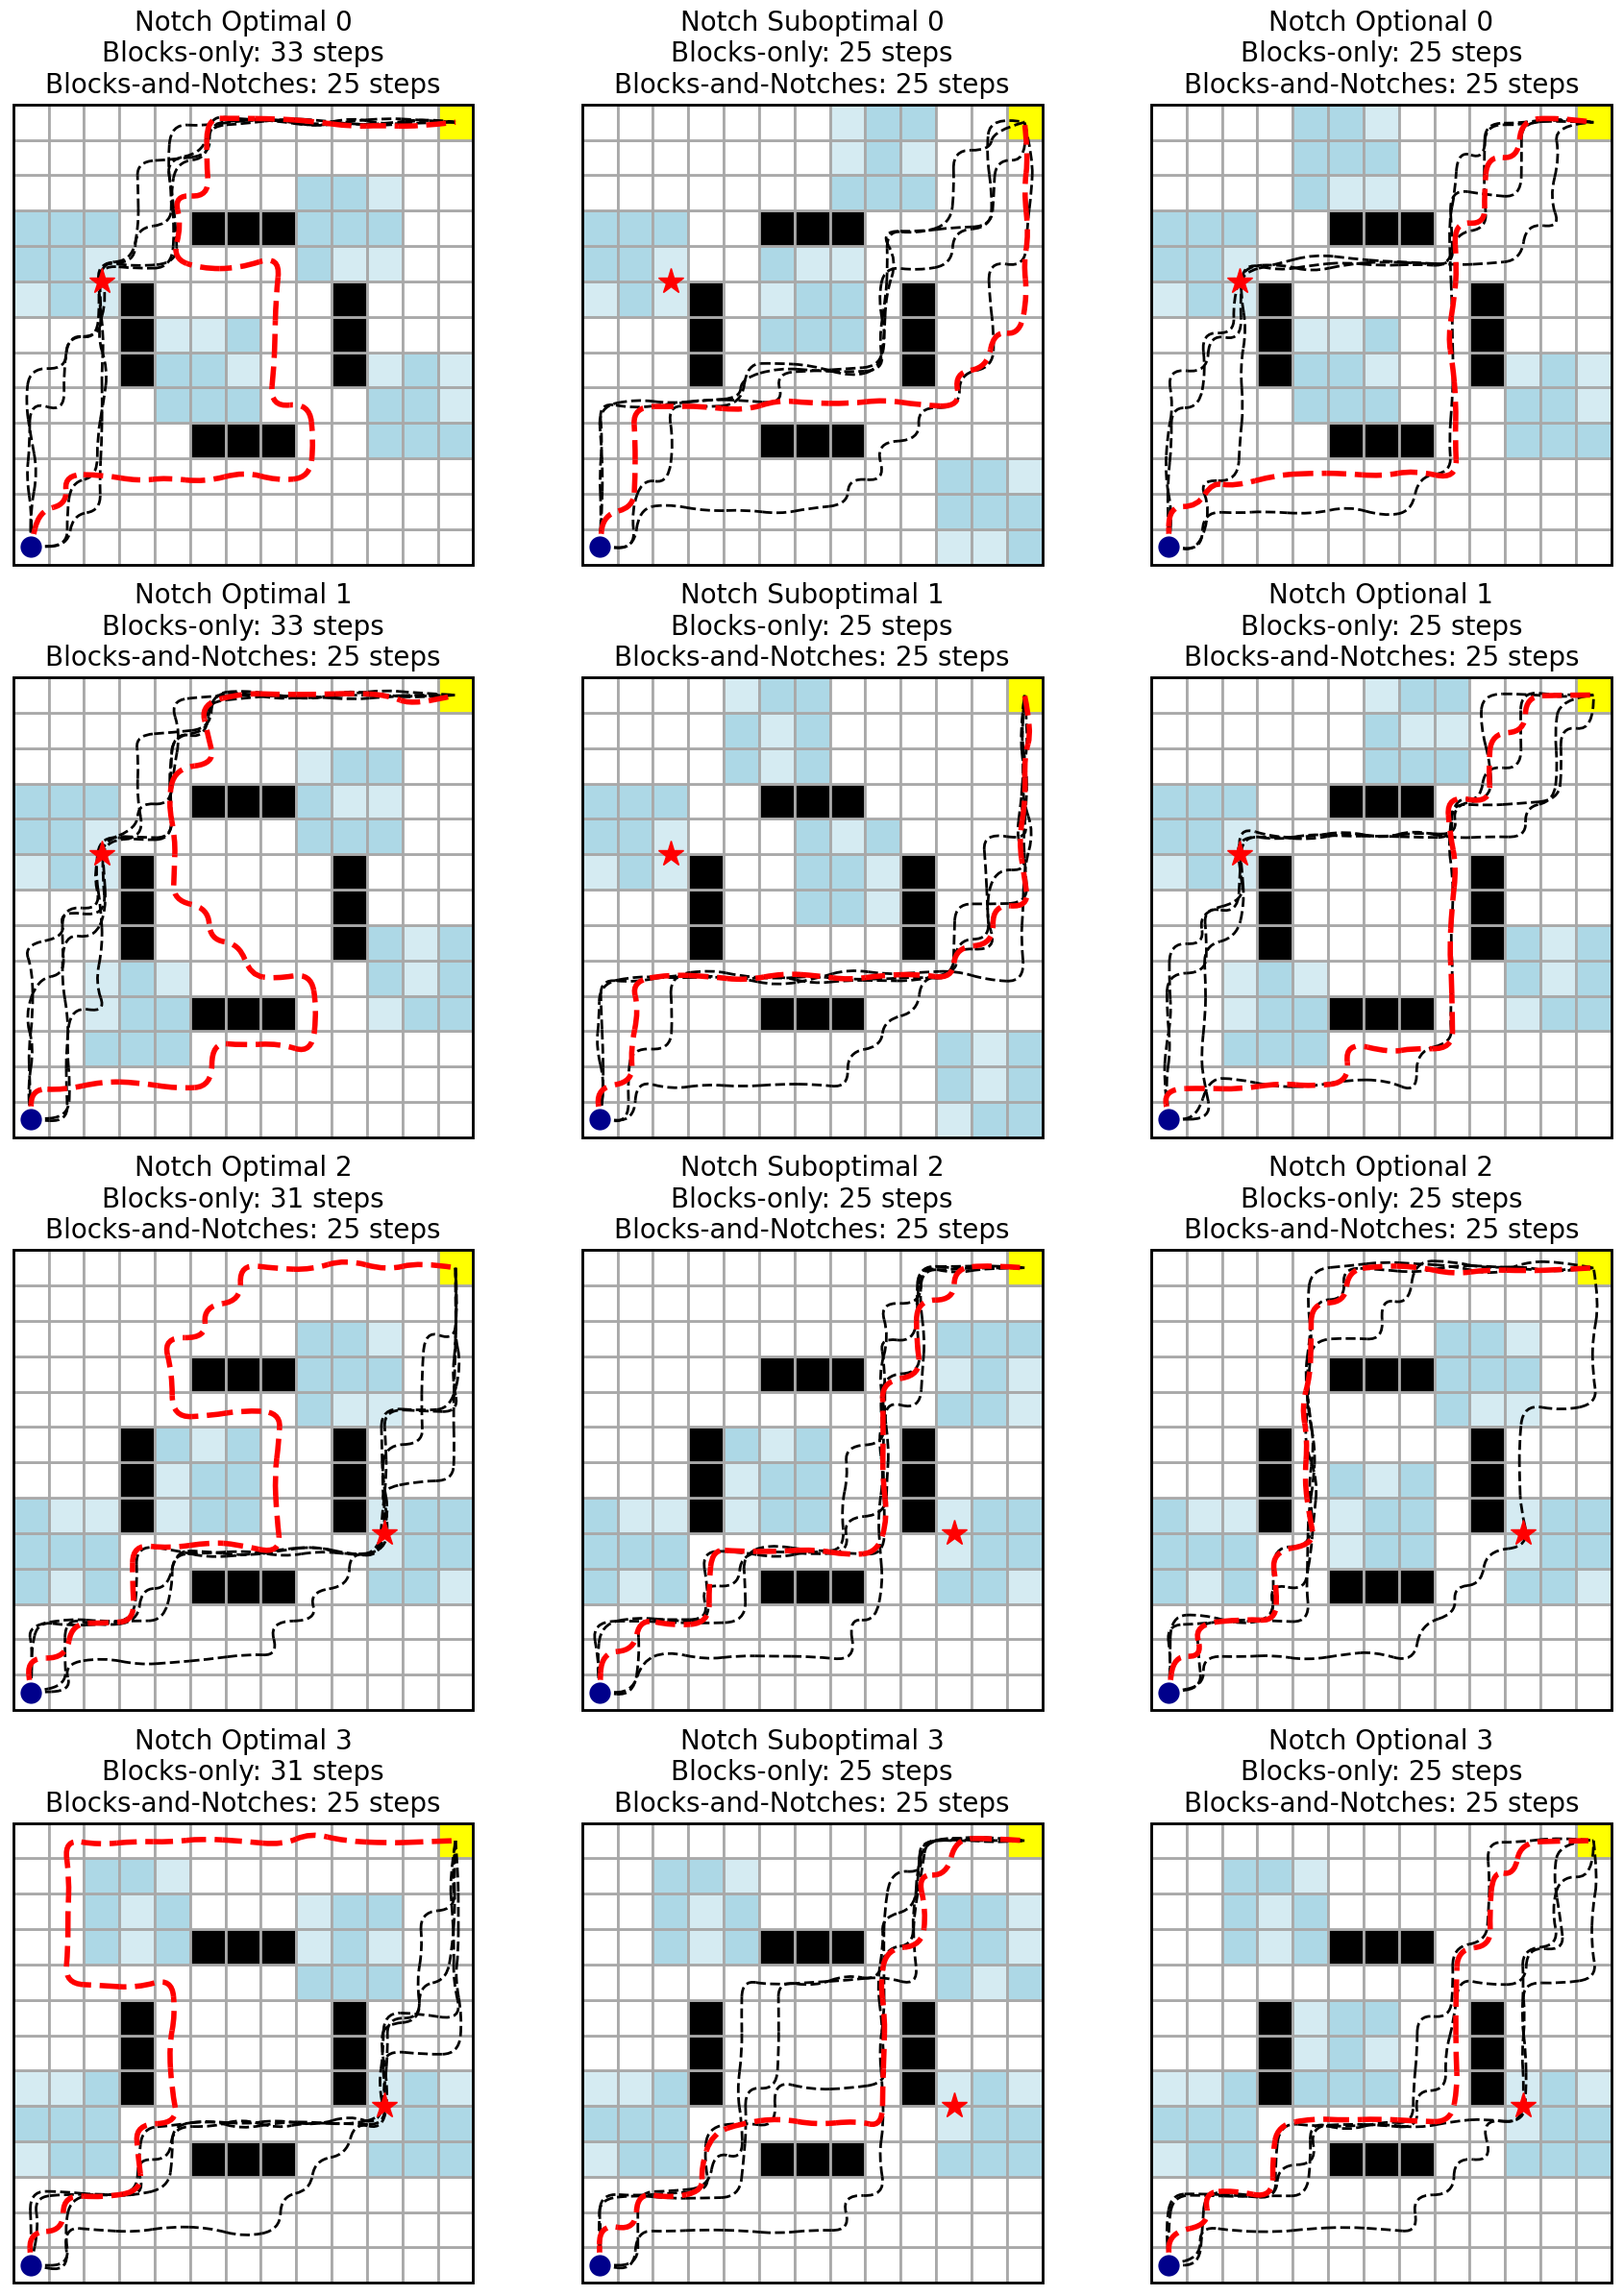

In [21]:
from msdm.domains import GridWorld
fine_test_maze_stats = {s['maze_name']: s for s in maze_stats if 'fine-test' in s['maze_name']}
coarse_test_maze_stats = {s['maze_name']: s for s in maze_stats if 'coarse-test' in s['maze_name']}
both_test_maze_stats= {s['maze_name']: s for s in maze_stats if 'both-test' in s['maze_name']}

idx_crit_locs = {i: calculate_critical_broken_locs(fine_test_mazes[f'{i}-fine-test']) for i in range(4)}

# fig, axes = plt.subplots(len(fine_test_maze_stats), 2, figsize=(6*2, 6*len(fine_test_maze_stats)))
fig, axes = plt.subplots(len(fine_test_maze_stats), 3, figsize=(6*3, 6*len(fine_test_maze_stats)))
assert len(fine_test_maze_stats) == len(coarse_test_maze_stats) == 4
test_maze_stats = {**fine_test_maze_stats, **coarse_test_maze_stats, **both_test_maze_stats}
for i in range(4):
    for j, maze_name in enumerate([f"{i}-fine-test", f"{i}-coarse-test", f"{i}-both-test"]):
        gw_stats = test_maze_stats[maze_name]
        gw = GridWorld(
            tile_array=gw_stats['tile_array'],
            initial_features='@',
            absorbing_features='$',
            wall_features='#ABCDEFGHIJK',
            discount_rate=.9999,
        )
        gwp = gw.plot(
            ax=axes[i, j],
            featurecolors={
                **{c: MAIN_OBSTACLE_COLOR for c in "ABCDEFG"},
                **{c: BROKEN_OBSTACLE_COLOR for c in "abcdefg"},
                "#": 'k',
                '$': 'yellow'
            },
            plot_walls=False,
            plot_initial_states=False,
            plot_absorbing_states=False
        )
        gwp.ax.plot(
            .5, .5,
            color='darkblue',
            marker='o',
            markersize=18,
            markeredgewidth=2,
            mec='w',
        )
        fine_policy = PolicyIteration().plan_on(gw).policy
        rng = random.Random(42112)
        for _ in range(4):
            fine_traj = fine_policy.run_on(gw, rng=rng)
            gwp.plot_trajectory(fine_traj.state_traj, lw=2, ls='--', color='k')
        gw_coarse = GridWorld(
            tile_array=gw_stats['tile_array'],
            initial_features='@',
            absorbing_features='$',
            wall_features='#ABCDEFGHIJKabcdefg',
            discount_rate=.9999,
        )
        coarse_policy = PolicyIteration().plan_on(gw_coarse).policy
        coarse_traj = coarse_policy.run_on(gw, rng=random.Random(12319))
        gwp.plot_trajectory(coarse_traj.state_traj, lw=4, ls='--', color='r')

        test_type = {
            "fine": "Notch Optimal",
            "coarse": "Notch Suboptimal",
            "both": "Notch Optional"
        }[maze_name.split('-')[1]]
        gwp.title(f"{test_type} {i}\nBlocks-only: {len(coarse_traj.state_traj)} steps\nBlocks-and-Notches: {len(fine_traj.state_traj)} steps", fontsize=20)
        
        mean_crit_loc = np.mean([[loc['x'], loc['y']] for loc in idx_crit_locs[i]], axis=0)
        gwp.ax.plot(
            *(mean_crit_loc + .5),
            color='red',
            marker="*",
            markersize=20,
        )
plt.tight_layout()
plt.savefig("./figures/fine-coarse-both-test_0-3.png", dpi=300, transparent=False, facecolor='w')